# Exploring P4 and its applications for QoS in video streaming

## By: Matthew Bulger

This notebook is based off of the P4 FABRIC example (complex_recipes/P4_bmv2) to experiment with HTTP/2 and QUIC video streaming in the FABRIC testbed.

## Basic FABRIC Slice Configuration

In [1]:
import json
import traceback
from fabrictestbed_extensions.fablib.fablib import fablib

In [2]:
try:
    print(f"{fablib.list_sites()}")
except Exception as e:
    print(f"Exception: {e}")

Name      CPUs  Cores    RAM (G)    Disk (G)       Basic (100 Gbps NIC)    ConnectX-6 (100 Gbps x2 NIC)    ConnectX-5 (25 Gbps x2 NIC)    P4510 (NVMe 1TB)    Tesla T4 (GPU)    RTX6000 (GPU)
------  ------  -------  ---------  -------------  ----------------------  ------------------------------  -----------------------------  ------------------  ----------------  ---------------
MICH         6  132/192  1360/1536  60470/60600    373/381                 2/2                             2/2                            10/10               2/2               3/3
WASH         6  180/192  1500/1536  60398/60600    370/381                 2/2                             2/2                            10/10               2/2               3/3
TACC        10  206/320  2068/2560  114422/116400  553/635                 2/2                             2/4                            16/16               4/4               6/6
UTAH        10  226/320  2312/2560  115970/116400  612/635                 2/2

## Configure Slice Parameters

In this section, we configure the slice paramters to have 3 end hosts, `h1`, `h2`, and `h3`, which are connected with 3 P4 switches, `s1`, `s2`, and `s3`.



In [32]:
from ipaddress import ip_address, IPv4Address, IPv6Address, IPv4Network, IPv6Network

# Slice 
slice_name = 'p4_video_streaming'

[site1,site2,site3] = fablib.get_random_sites(count=3)
site1 = site2 = site3 = "TACC" # I was only able to get this working with all nodes on the same site currently
print(f"Sites: {site1},{site2},{site3}")

# Switches
s1_name = "s1"
s2_name = "s2"
s3_name = "s3"

switch_cores = 2
switch_ram = 8
switch_disk = 100

# Hosts
h1_name = "h1"
h2_name = "h2"
h3_name = "h3"

h1_subnet=IPv4Network('10.0.1.0/24')
h1_addr=IPv4Address('10.0.1.1')

h2_subnet=IPv4Network('10.0.2.0/24')
h2_addr=IPv4Address('10.0.2.2')

h3_subnet=IPv4Network('10.0.3.0/24')
h3_addr=IPv4Address('10.0.3.3')

host_cores = 2
host_ram = 8
host_disk = 10
server_disk = 100

net_h1_name = 'net_h1'
net_h2_name = 'net_h2'
net_h3_name = 'net_h3'

net_s1_s2_name = 'net_s1_s2'
net_s2_s3_name = 'net_s2_s3'
net_s1_s3_name = 'net_s1_s3'

# All node properties
image = 'default_ubuntu_20'

Sites: TACC,TACC,TACC


### Create the Slice

In [33]:
try:
    #Create Slice
    slice = fablib.new_slice(name=slice_name)
    
    # Add switch node s1
    s1 = slice.add_node(name=s1_name, site=site1,  image=image, 
                        cores=switch_cores, ram=switch_ram, disk=switch_disk)
    s1.set_capacities(cores=switch_cores, ram=switch_ram, disk=switch_disk)
    s1_iface_local = s1.add_component(model='NIC_Basic', name="s1_local_nic").get_interfaces()[0]
    s1_iface_to_s2 = s1.add_component(model='NIC_Basic', name="s1_switch_nic1").get_interfaces()[0]
    s1_iface_to_s3 = s1.add_component(model='NIC_Basic', name="s1_switch_nic2").get_interfaces()[0]

    # Add switch node s2
    s2 = slice.add_node(name=s2_name, site=site2,  image=image, 
                        cores=switch_cores, ram=switch_ram, disk=switch_disk)
    s2_iface_local = s2.add_component(model='NIC_Basic', name="s2_local_nic").get_interfaces()[0]
    s2_iface_to_s1 = s2.add_component(model='NIC_Basic', name="s2_switch_nic1").get_interfaces()[0]
    s2_iface_to_s3 = s2.add_component(model='NIC_Basic', name="s2_switch_nic2").get_interfaces()[0]
    
    # Add switch node s3
    s3 = slice.add_node(name=s3_name, site=site3,  image=image, 
                        cores=switch_cores, ram=switch_ram, disk=switch_disk)
    s3_iface_local = s3.add_component(model='NIC_Basic', name="s3_local_nic").get_interfaces()[0]
    s3_iface_to_s1 = s3.add_component(model='NIC_Basic', name="s3_switch_nic1").get_interfaces()[0]
    s3_iface_to_s2 = s3.add_component(model='NIC_Basic', name="s3_switch_nic2").get_interfaces()[0]    
    
    # Add host node h1
    h1 = slice.add_node(name=h1_name, site=site1, image=image,
                        cores=host_cores, ram=host_ram, disk=host_disk)
    h1_iface = h1.add_component(model='NIC_Basic', name="h1_nic").get_interfaces()[0]
    
    # Add host node h2
    h2 = slice.add_node(name=h2_name, site=site2, image=image,
                        cores=host_cores, ram=host_ram, disk=server_disk)
    h2_iface = h2.add_component(model='NIC_Basic', name="h2_nic").get_interfaces()[0]
    
    # Add host node h3
    h3 = slice.add_node(name=h3_name, site=site3, image=image,
                        cores=host_cores, ram=host_ram, disk=host_disk)
    h3_iface = h3.add_component(model='NIC_Basic', name="h3_nic").get_interfaces()[0]
    
    #Add swtich networks
    switch_net1 = slice.add_l2network(name=net_s1_s2_name, interfaces=[s1_iface_to_s2, s2_iface_to_s1])
    swtich_net2 = slice.add_l2network(name=net_s2_s3_name, interfaces=[s2_iface_to_s3, s3_iface_to_s2])
    swtich_net3 = slice.add_l2network(name=net_s1_s3_name, interfaces=[s3_iface_to_s1, s1_iface_to_s3])

    #Add host networks 
    host_net1 = slice.add_l2network(name=net_h1_name, interfaces=[s1_iface_local, h1_iface])
    host_net2 = slice.add_l2network(name=net_h2_name, interfaces=[s2_iface_local, h2_iface])
    host_net3 = slice.add_l2network(name=net_h3_name, interfaces=[s3_iface_local, h3_iface])
    
    #Submit Slice Request
    slice.submit() 
except Exception as e:
    print(f"Error: {e}")
    traceback.print_exc()
    


-----------  ------------------------------------
Slice Name   p4_video_streaming
Slice ID     7370ea88-d3aa-4043-8204-6b71ec1d7c23
Slice State  StableOK
Lease End    2022-12-08 02:44:17 +0000
-----------  ------------------------------------

Retry: 9, Time: 189 sec

ID                                    Name    Site    Host                          Cores    RAM    Disk  Image              Management IP    State    Error
------------------------------------  ------  ------  --------------------------  -------  -----  ------  -----------------  ---------------  -------  -------
c62c73f2-62d2-4eff-8486-aadb0833ab57  s1      TACC    tacc-w2.fabric-testbed.net        2      8     100  default_ubuntu_20  129.114.110.69   Active
7427bc68-e8c2-431a-b522-7ceadacde9c0  s2      TACC    tacc-w2.fabric-testbed.net        2      8     100  default_ubuntu_20  129.114.110.91   Active
28f094db-e33a-4a86-b7b3-d8d773228905  s3      TACC    tacc-w2.fabric-testbed.net        2      8     100  default_ub

## Observe the Slice's Attributes

### Print the slice

In [34]:
try:
    slice = fablib.get_slice(name=slice_name)
    print(f"{slice}")
except Exception as e:
    print(f"Exception: {e}")

-----------  ------------------------------------
Slice Name   p4_video_streaming
Slice ID     7370ea88-d3aa-4043-8204-6b71ec1d7c23
Slice State  StableOK
Lease End    2022-12-08 02:44:17 +0000
-----------  ------------------------------------


### Print the Node List

In [35]:
try:
    slice = fablib.get_slice(name=slice_name)

    print(f"{slice.list_nodes()}")
except Exception as e:
    print(f"Exception: {e}")

ID                                    Name    Site    Host                          Cores    RAM    Disk  Image              Management IP    State    Error
------------------------------------  ------  ------  --------------------------  -------  -----  ------  -----------------  ---------------  -------  -------
c62c73f2-62d2-4eff-8486-aadb0833ab57  s1      TACC    tacc-w2.fabric-testbed.net        2      8     100  default_ubuntu_20  129.114.110.69   Active
7427bc68-e8c2-431a-b522-7ceadacde9c0  s2      TACC    tacc-w2.fabric-testbed.net        2      8     100  default_ubuntu_20  129.114.110.91   Active
28f094db-e33a-4a86-b7b3-d8d773228905  s3      TACC    tacc-w2.fabric-testbed.net        2      8     100  default_ubuntu_20  129.114.110.120  Active
85241462-fd6e-40c0-b4dd-e0bf6590b998  h1      TACC    tacc-w2.fabric-testbed.net        2      8      10  default_ubuntu_20  129.114.110.114  Active
f70c5399-f8bf-40de-ae57-5036c196dc6b  h2      TACC    tacc-w2.fabric-testbed.net        

### Print the Node Details

In [36]:
try:
    slice = fablib.get_slice(name=slice_name)
    for node in slice.get_nodes():
        print(f"{node}")
except Exception as e:
    print(f"Exception: {e}")

-----------------  -------------------------------------------------------------------------------------------------------------------------------
ID                 c62c73f2-62d2-4eff-8486-aadb0833ab57
Name               s1
Cores              2
RAM                8
Disk               100
Image              default_ubuntu_20
Image Type         qcow2
Host               tacc-w2.fabric-testbed.net
Site               TACC
Management IP      129.114.110.69
Reservation State  Active
Error Message
SSH Command        ssh -i /home/fabric/work/fabric_config/project-sliver -J mbulger1_0000023519@bastion-1.fabric-testbed.net ubuntu@129.114.110.69
-----------------  -------------------------------------------------------------------------------------------------------------------------------
-----------------  -------------------------------------------------------------------------------------------------------------------------------
ID                 7427bc68-e8c2-431a-b522-7ceadacde9c0
Name   

### Print the Node SSH Commands

In [ ]:
try:
    slice = fablib.get_slice(name=slice_name)
    for node in slice.get_nodes():
        print(f"{node.get_name()}: {node.get_ssh_command()}")
except Exception as e:
    print(f"Exception: {e}")

### Print the Interfaces

In [37]:
try:
    slice = fablib.get_slice(name=slice_name)
    
    print(f"{slice.list_interfaces()}")
except Exception as e:
    print(f"Exception: {e}")

Name                  Node    Network      Bandwidth  VLAN    MAC                Physical OS Interface    OS Interface
--------------------  ------  ---------  -----------  ------  -----------------  -----------------------  --------------
s1-s1_switch_nic2-p1  s1      net_s1_s3            0          02:EE:00:C6:75:96  ens9                     ens9
s1-s1_local_nic-p1    s1      net_h1               0          02:2A:1F:68:A6:C7  ens7                     ens7
s1-s1_switch_nic1-p1  s1      net_s1_s2            0          02:7F:22:D0:3A:53  ens8                     ens8
s2-s2_switch_nic2-p1  s2      net_s2_s3            0          06:A8:0F:D7:32:FB  ens8                     ens8
s2-s2_local_nic-p1    s2      net_h2               0          0A:A6:17:C6:65:D0  ens9                     ens9
s2-s2_switch_nic1-p1  s2      net_s1_s2            0          06:09:BC:72:F3:EF  ens7                     ens7
s3-s3_switch_nic1-p1  s3      net_s1_s3            0          1A:3E:34:21:4F:BB  ens9         

## Configure Nodes


In [38]:
config_threads = {}

In [39]:
host_config_script = "sudo apt-get update -qq && sudo apt-get install -qq -y python3-scapy && git clone https://github.com/p4lang/tutorials.git/" 

try:
    
    
    h1 = slice.get_node(name=h1_name)        
    if type(ip_address(h1.get_management_ip())) is IPv6Address:
        h1.execute("sudo sed -i '/nameserver/d' /etc/resolv.conf && sudo sh -c 'echo nameserver 2a00:1098:2c::1 >> /etc/resolv.conf' && sudo sh -c 'echo nameserver 2a01:4f8:c2c:123f::1 >> /etc/resolv.conf' && sudo sh -c 'echo nameserver 2a00:1098:2b::1 >> /etc/resolv.conf'")
       
    h1_os_iface = h1.get_interface(network_name=net_h1_name)
    h1_os_iface.ip_addr_add(addr=h1_addr, subnet=h1_subnet)
    h1_config_thread = h1.execute_thread(host_config_script)
    config_threads[h1] = h1_config_thread

    
    h2 = slice.get_node(name=h2_name)
    if type(ip_address(h2.get_management_ip())) is IPv6Address:
        h2.execute("sudo sed -i '/nameserver/d' /etc/resolv.conf && sudo sh -c 'echo nameserver 2a00:1098:2c::1 >> /etc/resolv.conf' && sudo sh -c 'echo nameserver 2a01:4f8:c2c:123f::1 >> /etc/resolv.conf' && sudo sh -c 'echo nameserver 2a00:1098:2b::1 >> /etc/resolv.conf'")
 
    h2_os_iface = h2.get_interface(network_name=net_h2_name)
    h2_os_iface.ip_addr_add(addr=h2_addr, subnet=h2_subnet)
    h2_config_thread = h2.execute_thread(host_config_script)
    config_threads[h2] = h2_config_thread

    h3 = slice.get_node(name=h3_name)
    if type(ip_address(h3.get_management_ip())) is IPv6Address:
        h3.execute("sudo sed -i '/nameserver/d' /etc/resolv.conf && sudo sh -c 'echo nameserver 2a00:1098:2c::1 >> /etc/resolv.conf' && sudo sh -c 'echo nameserver 2a01:4f8:c2c:123f::1 >> /etc/resolv.conf' && sudo sh -c 'echo nameserver 2a00:1098:2b::1 >> /etc/resolv.conf'")
 
    h3_os_iface = h3.get_interface(network_name=net_h3_name)
    h3_os_iface.ip_addr_add(addr=h3_addr, subnet=h3_subnet)
    h3_config_thread = h3.execute_thread(host_config_script)
    config_threads[h3] = h3_config_thread

except Exception as e:
    print(f"Error: {e}")
    traceback.print_exc()

## Configure Switches

Use ssh to configure the ifaces on the switches. This step requires testing the interfaces to figure out which interface is connected to which network.


#### Setup P4 Docker



Below are commands to let sudo work with the global proxy.

In [84]:
try:
    s1 = slice.get_node(name=s1_name)
    s1_h1_os_iface = s1.get_interface(network_name=net_h1_name)
    s1_s2_os_iface = s1.get_interface(network_name=net_s1_s2_name)
    s1_s3_os_iface = s1.get_interface(network_name=net_s1_s3_name)
    print(s1_h1_os_iface.get_os_interface(), s1_s2_os_iface.get_os_interface(), s1_s3_os_iface.get_os_interface())
        
    if type(ip_address(s1.get_management_ip())) is IPv4Address:
        management_ip_type = "IPv4"
    else:
        management_ip_type = "IPv6"
    print(management_ip_type)

    p4_program = "custom.p4"
    #p4_program = "custom_quic.p4"
    s1.upload_file(p4_program, p4_program)

    
    file_attributes = s1.upload_file('./scripts/router_setup_original.sh','router_setup_original.sh')
    file_attributes = s1.upload_file('./scripts/router_setup.sh','router_setup.sh')
    
    command=f"chmod +x router_setup_2.sh && sudo sh -c './router_setup.sh {management_ip_type} {s1_h1_os_iface.get_os_interface()} {s1_s2_os_iface.get_os_interface()} {s1_s3_os_iface.get_os_interface()} > /tmp/script.log 2>&1'"
    s1_config_thread = s1.execute_thread(command)
    config_threads[s1] = s1_config_thread


except Exception as e:
    print(f"Error: {e}")
    traceback.print_exc()

None None None
IPv4


In [81]:
try:
    s2 = slice.get_node(name=s2_name)
    s2_h2_os_iface = s2.get_interface(network_name=net_h2_name)
    s2_s1_os_iface = s2.get_interface(network_name=net_s1_s2_name)
    s2_s3_os_iface = s2.get_interface(network_name=net_s2_s3_name)
    print(s2_h2_os_iface.get_os_interface(), s2_s1_os_iface.get_os_interface(), s2_s3_os_iface.get_os_interface())

    if type(ip_address(s2.get_management_ip())) is IPv4Address:
        management_ip_type = "IPv4"
    else:
        management_ip_type = "IPv6"
    print(management_ip_type)
    
    s2.upload_file(p4_program, p4_program)
    
    file_attributes = s2.upload_file('./scripts/router_setup_original.sh','router_setup_original.sh')
    file_attributes = s2.upload_file('./scripts/router_setup_2.sh','router_setup_2.sh')
    
    command= f"chmod +x router_setup_2.sh && sudo sh -c './router_setup_2.sh  {management_ip_type} {s2_h2_os_iface.get_os_interface()} {s2_s1_os_iface.get_os_interface()} {s2_s3_os_iface.get_os_interface()}  > /tmp/script.log 2>&1'"
    s2_config_thread = s2.execute_thread(command)
    config_threads[s2] = s2_config_thread

except Exception as e:
    print(f"Error: {e}")
    traceback.print_exc() 

None None None
IPv4


In [85]:
try:
    s3 = slice.get_node(name=s3_name)
    s3_h3_os_iface = s3.get_interface(network_name=net_h3_name)
    s3_s1_os_iface = s3.get_interface(network_name=net_s1_s3_name)
    s3_s2_os_iface = s3.get_interface(network_name=net_s2_s3_name)
    print(s3_h3_os_iface.get_os_interface(), s3_s1_os_iface.get_os_interface(), s3_s2_os_iface.get_os_interface())

    if type(ip_address(s3.get_management_ip())) is IPv4Address:
        management_ip_type = "IPv4"
    else:
        management_ip_type = "IPv6"
    print(management_ip_type)
    
    s3.upload_file(p4_program, p4_program)
    
    file_attributes = s3.upload_file('./scripts/router_setup_original.sh','router_setup_original.sh')
    file_attributes = s3.upload_file('./scripts/router_setup_2.sh','router_setup_2.sh')
    
    command = f"chmod +x router_setup_2.sh && sudo sh -c './router_setup_2.sh  {management_ip_type} {s3_h3_os_iface.get_os_interface()} {s3_s1_os_iface.get_os_interface()} {s3_s2_os_iface.get_os_interface()} > /tmp/script.log 2>&1'"
    s3_config_thread = s3.execute_thread(command)
    config_threads[s3] = s3_config_thread


except Exception as e:
    print(f"Error: {e}")
    traceback.print_exc() 

None None None
IPv4


In [76]:
try:
    for node, thread in config_threads.items():
        stdout, stderr = thread.result()
        print(f"Config thread node {node.get_name()} complete")
        print(f"stdout: {stdout}")
        print(f"stderr: {stderr}")
except Exception as e:
    print(f"Error: {e}")
    traceback.print_exc() 


Config thread node h1 complete
stdout: Selecting previously unselected package python3-backcall.
(Reading database ... 63577 files and directories currently installed.)
Preparing to unpack .../00-python3-backcall_0.1.0-2_all.deb ...
Unpacking python3-backcall (0.1.0-2) ...
Selecting previously unselected package python3-decorator.
Preparing to unpack .../01-python3-decorator_4.4.2-0ubuntu1_all.deb ...
Unpacking python3-decorator (4.4.2-0ubuntu1) ...
Selecting previously unselected package python3-parso.
Preparing to unpack .../02-python3-parso_0.5.2-1ubuntu1_all.deb ...
Unpacking python3-parso (0.5.2-1ubuntu1) ...
Selecting previously unselected package python3-jedi.
Preparing to unpack .../03-python3-jedi_0.15.2-1_all.deb ...
Unpacking python3-jedi (0.15.2-1) ...
Selecting previously unselected package python3-pickleshare.
Preparing to unpack .../04-python3-pickleshare_0.7.5-2_all.deb ...
Unpacking python3-pickleshare (0.7.5-2) ...
Selecting previously unselected package python3-wcwid

## Generate Commands for P4 Switches

The current implemenation of this project does not implement ARP self-learning, which means we need to manually configure our switches with the MAC address of the next hop. 

In [78]:
config_name = "both_paths_quic"

In [87]:
base_command = "table_add ipv4_lpm set_nhop"

s3_config = [("10.0.1.0/24", (s1_s3_os_iface.get_mac(), "2", s1_s3_os_iface.get_mac(), "2")),
            ("10.0.2.0/24", (s2_s3_os_iface.get_mac(), "3", s2_s3_os_iface.get_mac(), "3"))]

both_paths = {
    s1_name: [("10.0.1.0/24", (h1_os_iface.get_mac(), "1", h1_os_iface.get_mac(), "1")),
             ("10.0.2.0/24", (s2_s1_os_iface.get_mac(), "2", s3_s1_os_iface.get_mac(), "3"))],
    s2_name: [("10.0.1.0/24", (s1_s2_os_iface.get_mac(), "2", s3_s2_os_iface.get_mac(), "3")),
             ("10.0.2.0/24", (h2_os_iface.get_mac(), "1", h2_os_iface.get_mac(), "1"))],
    s3_name: s3_config
}

fast_path = {
    s1_name: [("10.0.1.0/24", (h1_os_iface.get_mac(), "1", h1_os_iface.get_mac(), "1")),
             ("10.0.2.0/24", (s2_s1_os_iface.get_mac(), "2", s2_s1_os_iface.get_mac(), "2"))],
    s2_name: [("10.0.1.0/24", (s1_s2_os_iface.get_mac(), "2", s1_s2_os_iface.get_mac(), "2")),
             ("10.0.2.0/24", (h2_os_iface.get_mac(), "1", h2_os_iface.get_mac(), "1"))],
    s3_name: []
}

slow_path = {
    s1_name: [("10.0.1.0/24", (h1_os_iface.get_mac(), "1", h1_os_iface.get_mac(), "1")),
             ("10.0.2.0/24", (s3_s1_os_iface.get_mac(), "3", s3_s1_os_iface.get_mac(), "3"))],
    s2_name: [("10.0.1.0/24", (s3_s2_os_iface.get_mac(), "3", s3_s2_os_iface.get_mac(), "3")),
             ("10.0.2.0/24", (h2_os_iface.get_mac(), "1", h2_os_iface.get_mac(), "1"))],
    s3_name: s3_config
}

both_paths_quic = {
    s1_name: [("10.0.1.0/24", (s1_h1_os_iface.get_mac(), h1_os_iface.get_mac(), "1", s1_h1_os_iface.get_mac(), h1_os_iface.get_mac(), "1")),
             ("10.0.2.0/24", (s1_s2_os_iface.get_mac(), s2_s1_os_iface.get_mac(), "2", s1_s3_os_iface.get_mac(), s3_s1_os_iface.get_mac(), "3"))],
    s2_name: [("10.0.1.0/24", (s2_s1_os_iface.get_mac(), s1_s2_os_iface.get_mac(), "2", s2_s3_os_iface.get_mac(), s3_s2_os_iface.get_mac(), "3")),
             ("10.0.2.0/24", (s2_h2_os_iface.get_mac(), h2_os_iface.get_mac(), "1", s2_h2_os_iface.get_mac(), h2_os_iface.get_mac(), "1"))],
    s3_name: [("10.0.1.0/24", (s3_s1_os_iface.get_mac(), s1_s3_os_iface.get_mac(), "2", s3_s1_os_iface.get_mac(), s1_s3_os_iface.get_mac(), "2")),
            ("10.0.2.0/24", (s3_s2_os_iface.get_mac(), s2_s3_os_iface.get_mac(), "3", s3_s2_os_iface.get_mac(), s2_s3_os_iface.get_mac(), "3"))]
}

all_configs = {
    "both_paths": both_paths,
    "fast_path": fast_path,
    "slow_path": slow_path,
    "both_paths_quic": both_paths_quic
}

current_config = all_configs[config_name]

for switch_name in [s1_name, s2_name, s3_name]:
    config = current_config[switch_name]
    print(switch_name)
    with open(f'commands/{config_name}/{switch_name}_commands.txt', 'w') as f:
        for match, action in config:
            command = f"{base_command} {match} => {' '.join(action)}\n".lower()
            print(command)
            f.write(command)

s1
table_add ipv4_lpm set_nhop 10.0.1.0/24 => 02:2a:1f:68:a6:c7 1a:d4:14:82:e9:10 1 02:2a:1f:68:a6:c7 1a:d4:14:82:e9:10 1

table_add ipv4_lpm set_nhop 10.0.2.0/24 => 02:7f:22:d0:3a:53 06:09:bc:72:f3:ef 2 02:ee:00:c6:75:96 1a:3e:34:21:4f:bb 3

s2
table_add ipv4_lpm set_nhop 10.0.1.0/24 => 06:09:bc:72:f3:ef 02:7f:22:d0:3a:53 2 06:a8:0f:d7:32:fb 1a:19:74:69:7e:2f 3

table_add ipv4_lpm set_nhop 10.0.2.0/24 => 0a:a6:17:c6:65:d0 1e:51:7f:17:d6:38 1 0a:a6:17:c6:65:d0 1e:51:7f:17:d6:38 1

s3
table_add ipv4_lpm set_nhop 10.0.1.0/24 => 1a:3e:34:21:4f:bb 02:ee:00:c6:75:96 2 1a:3e:34:21:4f:bb 02:ee:00:c6:75:96 2

table_add ipv4_lpm set_nhop 10.0.2.0/24 => 1a:19:74:69:7e:2f 06:a8:0f:d7:32:fb 3 1a:19:74:69:7e:2f 06:a8:0f:d7:32:fb 3



### Confgure P4 Switch Tables

Edit sX_commands.txt to change the values

In [88]:
for switch_name in [s1_name, s2_name, s3_name]:
    switch_node = slice.get_node(name=switch_name)
    management_ip_switch = str(switch_node.get_management_ip())
    print("Swtitch Name        : {}".format(switch_node.get_name()))
    print("Management IP    : {}".format(management_ip_switch))
    
    #Configure P4 Tables
    cmd_file=f'{switch_name}_commands.txt'
    
    print(cmd_file)
    file_attributes = switch_node.upload_file(f'commands/{config_name}/{cmd_file}',cmd_file)
    print("file_attributes: {}".format(file_attributes))

    stdout = switch_node.execute(f"sudo sh -c 'cat {cmd_file} | docker exec -i fabric_p4 simple_switch_CLI'")
    print("stdout: {}".format(stdout))

Swtitch Name        : s1
Management IP    : 129.114.110.69
s1_commands.txt
file_attributes: -rw-rw-r--   1 1000     1000          238 07 Dec 06:16 ?
stdout: ('Obtaining JSON from switch...\nDone\nControl utility for runtime P4 table manipulation\nRuntimeCmd: Adding entry to lpm match table ipv4_lpm\nmatch key:           LPM-0a:00:01:00/24\naction:              set_nhop\nruntime data:        02:2a:1f:68:a6:c7\t1a:d4:14:82:e9:10\t00:01\t02:2a:1f:68:a6:c7\t1a:d4:14:82:e9:10\t00:01\nEntry has been added with handle 0\nRuntimeCmd: Adding entry to lpm match table ipv4_lpm\nmatch key:           LPM-0a:00:02:00/24\naction:              set_nhop\nruntime data:        02:7f:22:d0:3a:53\t06:09:bc:72:f3:ef\t00:02\t02:ee:00:c6:75:96\t1a:3e:34:21:4f:bb\t00:03\nEntry has been added with handle 1\nRuntimeCmd: \n', '')
Swtitch Name        : s2
Management IP    : 129.114.110.91
s2_commands.txt
file_attributes: -rw-rw-r--   1 1000     1000          238 07 Dec 06:16 ?
stdout: ('Obtaining JSON from switch.

## Set up routing rules for hosts

The above commands set up our P4 routers, but we still need to inform `h1` and `h2` to use these routes.

In [58]:
print(h1_os_iface.get_os_interface())
h1.execute(f"sudo ip route add 10.0.2.0/24 dev {h1_os_iface.get_os_interface()}")

ens7


('', '')

In [59]:
print(h2_os_iface.get_os_interface())
h2.execute(f"sudo ip route add 10.0.1.0/24 dev {h2_os_iface.get_os_interface()}")

ens7


('', '')

## Set up static ARP cache for hosts

With my current P4 program implementation, self-learning ARP is not currently functional. In order to communicate between the hosts, we need to statically configure the ARP tables on `h1` and `h2`.

In [60]:
print(s1_h1_os_iface.get_mac())
h1.execute("sudo apt install net-tools")
h1.execute(f"sudo arp -s 10.0.2.2 {s1_h1_os_iface.get_mac()}")

02:2A:1F:68:A6:C7


('', '')

In [61]:
print(s2_h2_os_iface.get_mac())
h2.execute("sudo apt install net-tools")
h2.execute(f"sudo arp -s 10.0.1.1 {s2_h2_os_iface.get_mac()}")

0A:A6:17:C6:65:D0


('', '')

## Set up Video Streaming Server

Next, we install the Apache HTTP/2 video streaming server on `h2`. We also download the "Big Buck Bunny" dataset, and extract the 4-second segments into the folder for apache to serve.

In [29]:
h1 = slice.get_node(name=h1_name)
h2 = slice.get_node(name=h2_name)

In [30]:
big_buck_bunny_url = "https://nyu.box.com/shared/static/d6btpwf5lqmkqh53b52ynhmfthh2qtby.tgz"

h2.execute("sudo apt install -y apache2")
h2.execute(f"wget {big_buck_bunny_url} -O media.tgz -o wget.log")
h2.execute("sudo tar -v -xzf media.tgz -C /var/www/html/")
h2.execute("ls /var/www/html/media/BigBuckBunny/4sec")

KeyboardInterrupt: 

## Set up HTTP/2 DASH Video Streaming Client

In [31]:
h1.execute("sudo apt install -y python2 ffmpeg")
h1.execute("git clone https://github.com/pari685/AStream")

('', "Cloning into 'AStream'...\n")

## Execute HTTP/2 DASH Streaming Client
Start streaming the video from the client to the server. For this experient, the client requests 30 segments using the `basic` adaptation policy.

In [ ]:
policy = "basic"
segments = 30

h1.execute(f"python2 ~/AStream/dist/client/dash_client.py -m http://10.0.2.2/media/BigBuckBunny/4sec/BigBuckBunny_4s.mpd -p '{policy}' -n {segments}")

Once the streaming is finished, list out the log files.

In [8]:
h1.execute("ls -alstr ~/")
h1.execute("ls -alstr ~/ASTREAM_LOGS")

('total 76\n 4 drwxrwxr-x 2 ubuntu ubuntu  4096 Nov 12 19:29 .\n 4 drwxr-xr-x 8 ubuntu ubuntu  4096 Nov 12 19:29 ..\n60 -rw-rw-r-- 1 ubuntu ubuntu 58032 Nov 12 19:31 DASH_RUNTIME_LOG_netflix_2022-11-12.19_29_36.log\n 4 -rw-rw-r-- 1 ubuntu ubuntu  2798 Nov 12 19:31 DASH_BUFFER_LOG_2022-11-12.19_29_36.csv\n 4 -rw-rw-r-- 1 ubuntu ubuntu  2393 Nov 12 19:31 ASTREAM_2022-11-12.19_29_36.json\n',
 '')

Download the log files for data analysis.

In [2]:
dash_buffer_log = "DASH_BUFFER_LOG_2022-11-14.03_47_29.csv"
save_path = "/home/fabric/work/jupyter-examples-rel1.3.3/fabric_examples/complex_recipes/P4_bmv2/csv"
h1.download_file(f"{save_path}/DASH_BUFFER_LOG.csv", f"/home/ubuntu/ASTREAM_LOGS/{dash_buffer_log}")

## Kill the P4 Switches

You can run the following block to kill BMv2 on all of the switches, which will obviously clear out the routing tables. You can go back up to the section on "Configure Switches" to restart the switches and add new routing rules.

In [72]:
for switch_obj in [s1, s2, s3]:
    o = switch_obj.execute("sudo docker exec -d -it fabric_p4 sh -c 'sudo killall -s 9 simple_switch'")
    print(o)

('', '')
('', '')
('', '')


## Data Analysis

Both Paths 374015.7878787879
Fast Path 304320.2121212121
Slow Path 241798.63636363635


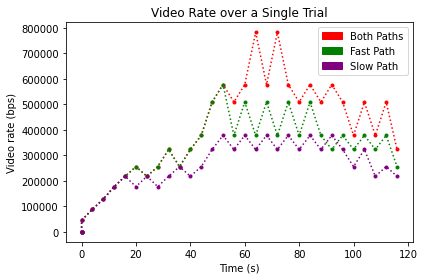

In [6]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
import numpy as np

c = {'INITIAL_BUFFERING': 'violet', 'PLAY': 'lightcyan', 'BUFFERING': 'lightpink'}

plt.title("Video Rate over a Single Trial");
plt.ylabel("Video rate (bps)")
plt.xlabel("Time (s)");
patches = []

files = [
            ("DASH_BUFFER_LOG_current4.csv", "purple", "Current-slow-5000-basic"),
            ("DASH_BUFFER_LOG_current9.csv", "purple", "Current-slow-5000-basic2"),
            ("DASH_BUFFER_LOG_current10.csv", "purple", "Current-slow-5000-basic2"),
            ("DASH_BUFFER_LOG_current11.csv", "purple", "Current-slow-5000-basic2"),
    
            ("DASH_BUFFER_LOG_current5.csv", "red", "Current-both-5000-basic"),
            ("DASH_BUFFER_LOG_current6.csv", "red", "Current-both-5000-basic2"),
            ("DASH_BUFFER_LOG_current12.csv", "red", "Current-both-5000-basic2"),

            ("DASH_BUFFER_LOG_current7.csv", "green", "Current-fast-5000-basic"),
            ("DASH_BUFFER_LOG_current8.csv", "green", "Current-fast-5000-basic2"),
            ("DASH_BUFFER_LOG_current13.csv", "green", "Current-fast-5000-basic2"),
]

# I selected 3 of the top 
files = [
    ("DASH_BUFFER_LOG_current12.csv", "red", "Both Paths"),
    ("DASH_BUFFER_LOG_current7.csv", "green", "Fast Path"),
    ("DASH_BUFFER_LOG_current4.csv", "purple", "Slow Path"),
]

for file, color, label in files:
    dash = pd.read_csv(f"{save_path}/{file}")
    #print(dash)
    
    dash = dash.loc[dash.CurrentPlaybackState.isin(c.keys() )]
    
    #print(dash)
    #[print(row) for row in dash.iterrows()]
    states = pd.DataFrame({'startState': dash.CurrentPlaybackState[0:-2].values, 'startTime': dash.EpochTime[0:-2].values,
                            'endState':  dash.CurrentPlaybackState[1:-1].values, 'endTime':   dash.EpochTime[1:-1].values})


    #for index, s in states.iterrows():
    #  plt.axvspan(s['startTime'], s['endTime'],  color=c[s['startState']], alpha=1) 

    plt.plot(dash[dash.Action!="Writing"].EpochTime, dash[dash.Action!="Writing"].Bitrate, '.:', color=color)
    patches.append(mpatches.Patch(color=color, label=label))
    print(label, np.average(dash[dash.Action!="Writing"].Bitrate))

    
plt.legend(handles=patches)
plt.tight_layout()
plt.savefig(f'{save_path}/single_trial.png', dpi=900)



[379200.8181818182, 352013.24242424243, 374015.7878787879]
[304320.2121212121, 298477.0, 296080.57575757575]
[241798.63636363635, 261129.72727272726, 271885.0606060606, 220049.0606060606]


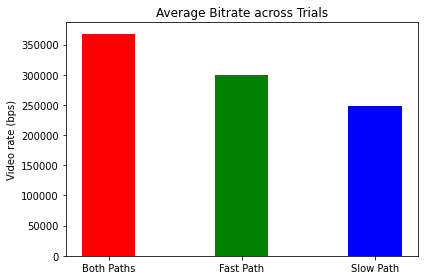

In [8]:
files_dict = {'Both Paths': ["DASH_BUFFER_LOG_current13.csv", "DASH_BUFFER_LOG_current6.csv", "DASH_BUFFER_LOG_current12.csv"],
              'Fast Path': ["DASH_BUFFER_LOG_current7.csv", "DASH_BUFFER_LOG_current8.csv", "DASH_BUFFER_LOG_current5.csv"],
              'Slow Path': ["DASH_BUFFER_LOG_current4.csv", "DASH_BUFFER_LOG_current9.csv", "DASH_BUFFER_LOG_current10.csv", "DASH_BUFFER_LOG_current11.csv"],
       }


keys = list(files_dict.keys())
files_arrays = list(files_dict.values())

data = []

for files in files_arrays:
    vals = []
    for file in files:
        dash = pd.read_csv(f"{save_path}/{file}")
        dash = dash.loc[dash.CurrentPlaybackState.isin(c.keys() )]
        val = np.average(dash[dash.Action!="Writing"].Bitrate)
        vals.append(val)
    data.append(np.average(vals))
    print(vals)

#print(data)
    
plt.bar(keys, data, color =("red", "green", "blue"), width = 0.4)
#plt.xlabel("Courses offered")
plt.ylabel("Video rate (bps)")
plt.title("Average Bitrate across Trials");
#plt.show()

plt.tight_layout()
plt.savefig(f'{save_path}/avg_trials.png', dpi=900)

# QUIC Video Streaming

In this section, we set up our server with a QUIC server to host the content instead of the HTTP/2 based solution. 

In [ ]:
h2.execute("git clone https://chromium.googlesource.com/chromium/tools/depot_tools.git")
h2.execute('export PATH="$PATH:${HOME}/depot_tools"')
h2.execute("mkdir ~/chromium && cd ~/chromium")
h2.execute("fetch --nohooks --no-history chromium")
h2.execute("cd src")
h2.execute("./build/install-build-deps.sh")
h2.execute("gclient runhooks")
h2.execute("gn gen out/Debug")


In [67]:
h1.execute("git clone https://github.com/sevketarisu/quic-streaming.git")

('', "Cloning into 'quic-streaming'...\n")

In [ ]:
policy = "basic"
segments = 30

h1.execute(f"python2 ~/quic-streaming/AStreamPlayerQUIC/src/dist/client/dash_client.py -m http://10.0.2.2/media/BigBuckBunny/4sec/BigBuckBunny_4s.mpd -p '{policy}' -n {segments} --QUIC")

## Delete Slice

In [ ]:
try:
    slice = fablib.get_slice(name=slice_name)
    slice.delete()
except Exception as e:
    print(f"Fail: {e}")
    traceback.print_exc()